## ***Messages***

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage

In [2]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="AlAmin"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Zoo in the US.", name="AlAmin"))

for msg in messages:
    msg.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: AlAmin

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: AlAmin

I want to learn about the best place to see Zoo in the US.


In [3]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import requests
import os

In [4]:
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

In [5]:
llm = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [7]:
response = llm.invoke(messages)
print(type(response))

<class 'langchain_core.messages.ai.AIMessage'>


## Define the tools

In [8]:
def multiply(a: int, b: int) ->int:
    """
    This function multiply tow integer number a and b
    
    Args:
        a: first int
        b: second int
    """
    return a*b

In [9]:
llm_with_tools = llm.bind_tools([multiply])

In [12]:
response = llm_with_tools.invoke(
    [
        HumanMessage(content="What is 2 multiplied by 3", name="AlAmin")
    ]
)

In [13]:
response.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_sh9f',
  'type': 'tool_call'}]

## Using messages as state

In [14]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

# ***Reducers***
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [15]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built MessagesState!

MessagesState is defined:

- With a pre-build single messages key
- This is a list of AnyMessage objects
- It uses the add_messages reducer

We'll usually use MessagesState because it is less verbose than defining a custom TypedDict, as shown above.

In [16]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

*now time to see how `add_messages` reducer work in isolation*

In [17]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="AlAmin")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

In [18]:
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='19f0842f-c59a-4456-8787-a448f595bf69'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='AlAmin', id='732405f3-fda2-4538-b44b-40087fe83a81'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='d55e3240-c604-4697-90f9-dcee8247eeab')]

## Our Graph

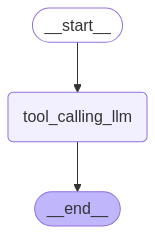

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

## Define the node
def tool_calling_llm(state: MessagesState):
    return {
        'messages': [llm_with_tools.invoke(state['messages'])]
    }
    
## build the graph
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

# display
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
messages = graph.invoke(
    {
        'messages': HumanMessage(content="Assalamualikum sir")
    }
)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Assalamualikum sir
================================== Ai Message ==================================

Wa alaikumussalam! How can I assist you today?


In [32]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_gyk7)
 Call ID: call_gyk7
  Args:
    a: 2
    b: 3
